In [60]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append('../../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, lrna_price, usd_price, execute_swap, execute_add_liquidity, execute_remove_liquidity, cash_out_omnipool
from model.amm.agents import Agent
from model.amm.trade_strategies import price_manipulation, omnipool_arbitrage
from model.amm.global_state import GlobalState, value_assets

In [61]:
# same seed, same parameters = same simulation result[[
# random.seed(42)


tokens = {
    'HDX': {'liquidity': 44000000, 'LRNA': 275143},
    'WETH': {'liquidity': 1400, 'LRNA': 2276599},
    'DAI': {'liquidity': 2268262, 'LRNA': 2268262},
    'DOT': {'liquidity': 88000, 'LRNA': 546461},
    'WBTC': {'liquidity': 47, 'LRNA': 1145210},
}

initial_state = OmnipoolState(
    tokens=tokens,
    lrna_fee=0.0005,
    asset_fee=0.0025,
    preferred_stablecoin='DAI'
)

market_prices = {tkn: usd_price(initial_state, tkn) for tkn in initial_state.asset_list}

DOT_shares_total = initial_state.shares['DOT']
# lp_percentage = 0.5

agent_holdings = {
    'DAI': 10000000,
    'WETH': 100,
    'DOT': 10000000,
    'WBTC': 10,
    'HDX': 100000,
    'LRNA': 0,
    ('omnipool', 'DOT'): 0,
}

initial_state.protocol_shares['DOT'] -= agent_holdings[('omnipool', 'DOT')]

# agent_prices = {
#     ('omnipool', 'DOT'): initial_price
# }

agent_delta_r = {
    ('omnipool', 'DOT'): 0.0
}

initial_agent = Agent(
    holdings=agent_holdings,
    delta_r=agent_delta_r
)

lp_percentage = 0.05
precision = 11
initial_prices = [round(4 + i * 4 / (precision - 1), 4) for i in range(precision)]
price_movements = [round(0.01 / (precision - 1) * i, 4) for i in range(precision)]
# price_movements = [0.01]
# initial_prices = [4.0]
results = [[[] for i in range(precision)] for j in range(precision)]

# for i, initial_price in enumerate(price_movements):
#     print(i, initial_price)
    
for i, initial_price in enumerate(initial_prices):
    for j, price_movement in enumerate(price_movements):
        # print(initial_price)
        test_agent = initial_agent.copy()
        test_state = initial_state.copy()
        
        test_agent.holdings[('omnipool', 'DOT')] = DOT_shares_total * lp_percentage
        
        test_state.protocol_shares['DOT'] -= agent_holdings[('omnipool', 'DOT')]
        test_agent.share_prices[('omnipool', 'DOT')] = initial_price
        buy_quantity = tokens['DOT']['liquidity'] - tokens['DOT']['liquidity'] / math.sqrt(1 + price_movement)
        
        trade_state, trade_agent = execute_swap(
            state=test_state.copy(),
            agent=test_agent.copy(),
            tkn_sell='DAI',
            tkn_buy='DOT',
            # sell_quantity=sell1_quantity
            buy_quantity=buy_quantity
        )

        withdraw_state, withdraw_agent = execute_remove_liquidity(
            state=trade_state.copy(),
            agent=trade_agent.copy(),
            quantity=trade_agent.holdings[('omnipool', 'DOT')],
            tkn_remove='DOT'
        )

        # sell_lrna_state, sell_lrna_agent = execute_swap(
        #     withdraw_state.copy(),
        #     withdraw_agent.copy(),
        #     tkn_sell='LRNA',
        #     tkn_buy='DAI',
        #     sell_quantity=withdraw_agent.holdings['LRNA']
        # )

        final_global_state = GlobalState(
            pools={'omnipool': withdraw_state.copy()},
            agents={'attacker': withdraw_agent.copy()},
            external_market=market_prices
        )
        # import math
        # omnipool = sell_lrna_state
        # state = final_global_state
        # asset1 = 'DAI'
        # asset2 = 'DOT'
        # delta_r = (math.sqrt((
        #                  omnipool.lrna[asset2] * omnipool.lrna[asset1] * omnipool.liquidity[asset2] *
        #                  omnipool.liquidity[asset1]
        #          ) / (state.external_market[asset2] / state.external_market[asset1])) - (
        #        omnipool.lrna[asset1] * omnipool.liquidity[asset2]
        # )) / (omnipool.lrna[asset2] + omnipool.lrna[asset1])
        #
        # arbed_pool, arbed_agent = oamm.execute_swap(
        #     state=sell_lrna_state.copy(),
        #     agent=sell_lrna_agent.copy(),
        #     tkn_sell='DOT',
        #     tkn_buy='DAI',
        #     sell_quantity=delta_r
        # )

        arb_state = omnipool_arbitrage('omnipool', 20).execute(
            state=final_global_state.copy(),
            agent_id='attacker'
        )

        arbed_pool = arb_state.pools['omnipool']
        arbed_agent = arb_state.agents['attacker']

        initial_wealth = cash_out_omnipool(test_state, test_agent, market_prices)
        no_arb_wealth = cash_out_omnipool(withdraw_state, withdraw_agent, market_prices)
        final_wealth = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)

        no_arb_profit = no_arb_wealth - initial_wealth
        profit = final_wealth - initial_wealth
    
        results[i][j] = profit #  , initial_price, price_movement)


In [62]:
# # for i, row in enumerate(results):
# #     print(initial_prices[i], ": ", [[round(item, 3) for item in result] for result in row])
# print(initial_prices)
# print(price_movements)

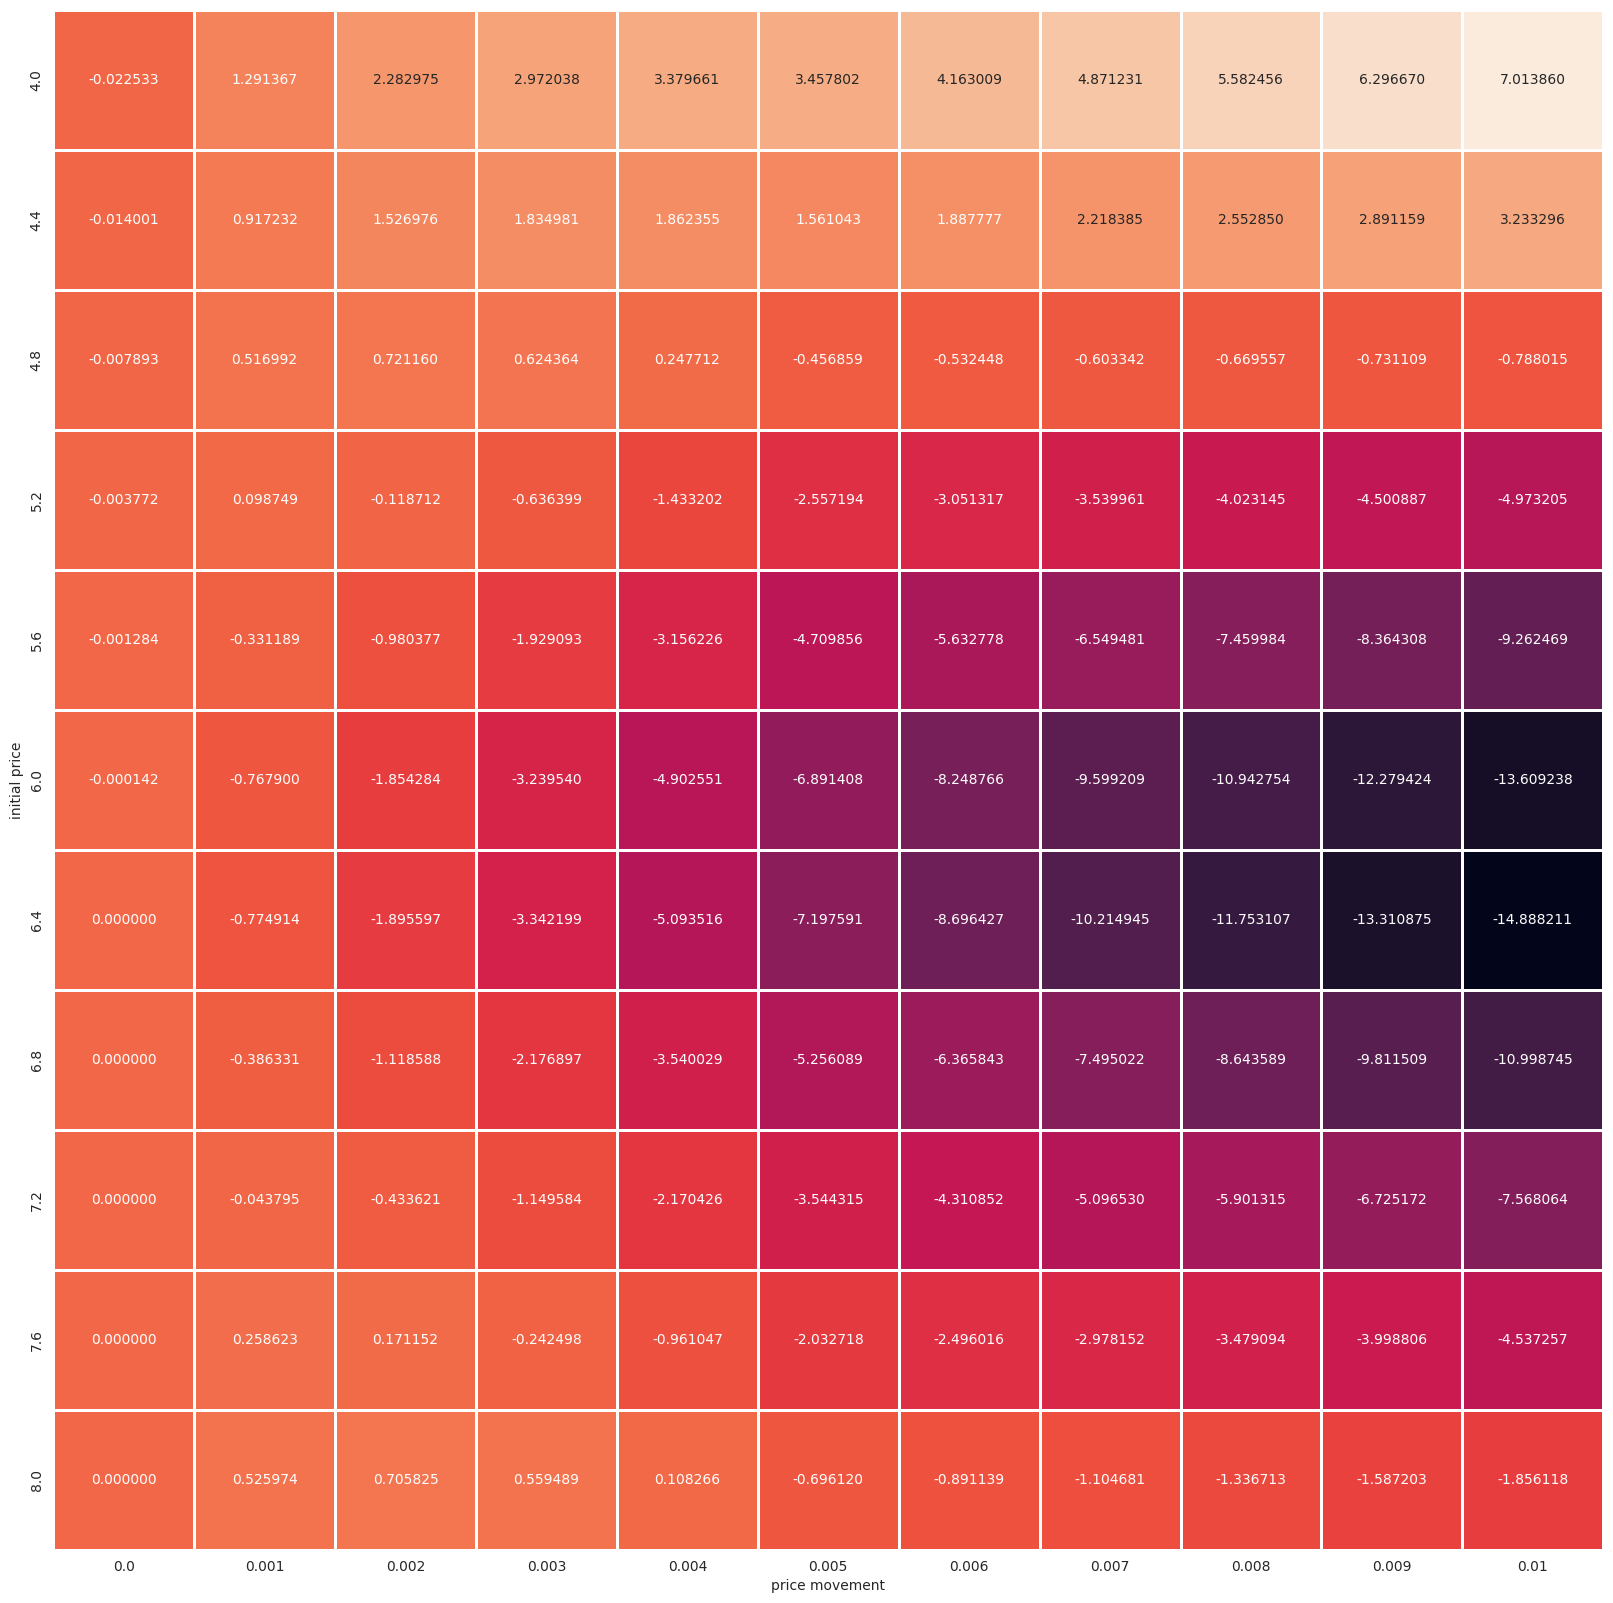

In [63]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(results, linewidth=1, annot=True, fmt='f', cbar=False, yticklabels=initial_prices, xticklabels=price_movements)
ax.set_ylabel('initial price')
ax.set_xlabel('price movement')
plt.show()

In [69]:
print(market_prices)
print({k: arb_state.pools['omnipool'].usd_price(arb_state.pools['omnipool'], k) for k in ['HDX', 'WETH', 'DAI', 'DOT', 'WBTC']})

{'HDX': 0.00625325, 'WETH': 1626.1421428571427, 'DAI': 1.0, 'DOT': 6.209784090909091, 'WBTC': 24366.17021276596, 'USD': 1}
{'HDX': 0.006253888083792451, 'WETH': 1626.292212272221, 'DAI': 1.0, 'DOT': 6.209770823903434, 'WBTC': 24368.418858081244}
